# Exercise 2: CG method for any convex or strongly convex functions

How can such methods be applied to non-quadratic problems? For example, for binary logistic regression:
$$
f(x)=\dfrac{\mu}{2}\| x \|^2_2 + \dfrac{1}{m}\sum_{i=1}^{m}log(1+exp(-y_i\langle a_i, x \rangle)) \longrightarrow \min_{x\in\mathbb{R}^n}
$$

We can use the Fletcher-Reeves or Polyak-Ribier method. Add the iteration in function `ConjugateGradientPR()` of the Polyak-Ribier method to the code:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skldata
import jax
from jax import numpy as jnp
from scipy.optimize import minimize_scalar
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
plt.rcParams['figure.dpi'] = 300



np.random.seed(228)

def generate_problem(m=1000, n=300, mu=1):
    np.random.seed(228)
    # Generating synthetic data
    n = 300  # Number of features
    m = 1000  # Number of samples

    # Create a binary classification problem
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)

    # Regularized logistic regression cost function
    @jax.jit
    def f(w):
        return jnp.linalg.norm(w)**2*mu/2 +  jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))
    
    grad_f = jax.jit(jax.grad(f))
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))

    return f, grad_f, x_0

# Optimization methods
def gradient_descent(f, grad_f, x_0, step_size, iterations):
    x = x_0.copy()
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad_f(x)))
    for _ in range(iterations):
        x -= step_size * grad_f(x)
        values.append(f(x))
        gradients.append(np.linalg.norm(grad_f(x)))
    return values, gradients

def steepest_descent(f, grad_f, x_0, iterations):
    x = x_0.copy()
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad_f(x)))
    for _ in range(iterations):
        grad = grad_f(x)
        res = minimize_scalar(lambda alpha: f(x - alpha * grad), bounds = (1e-8,1e1), method='Bounded', options={'maxiter': 50})
        step_size = res.x
        x -= step_size * grad
        values.append(f(x))
        gradients.append(np.linalg.norm(grad))
    return values, gradients

def ConjugateGradientFR(f, grad_f, x0, iterations, restart=False):
    x = x0
    grad = grad_f(x)
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad_f(x)))
    d = -grad
    it = 0
    while it < iterations:
        res = minimize_scalar(lambda alpha: f(x + alpha * d), bounds = (1e-9,1e1), method='Bounded', options={'maxiter': 50})
        alpha = res.x
        x = x + alpha * d
        values.append(f(x))
        gradients.append(np.linalg.norm(grad))
        grad_next = grad_f(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        d = -grad_next + beta * d
        grad = grad_next.copy()
        it += 1
        if restart and it % restart == 0:
            grad = grad_f(x)
            d = -grad
        
    return values, gradients

def ConjugateGradientPR(f, grad_f, x0, iterations, restart=False):
    x = x0
    grad = grad_f(x)
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad))
    d = -grad
    it = 0
    while it < iterations:
        # Line search for the optimal alpha
        res = minimize_scalar(lambda alpha: f(x + alpha * d), method='Brent', options={'maxiter': 50})
        alpha = res.x
        x += alpha * d
        grad_next = grad_f(x)
        grad_diff = grad_next - grad
        beta = (grad @ grad_diff) / (d @ grad_diff)
        beta = max(0, beta)
        d = -grad_next + beta * d
        grad = grad_next.copy()
        values.append(f(x))
        gradients.append(np.linalg.norm(grad))
        it += 1 
        if restart and it % restart == 0:
            d = -grad
    return values, gradients

def SR1(f, grad_f, x0, iterations):
    x = x0
    n = len(x0)
    C = np.eye(n)  # Initial approximation of inverse Hessian
    grad = grad_f(x)
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad))
    
    for it in range(iterations):
        # Search direction using inverse
        d = -C @ grad
        
        # Line search
        res = minimize_scalar(lambda alpha: f(x + alpha * d), bounds=(1e-9, 1e1), 
                            method='Bounded', options={'maxiter': 50})
        alpha = res.x
        
        # Update position
        x_new = x + alpha * d
        grad_new = grad_f(x_new)
        
        # SR1 inverse update
        s = alpha * d  # Step
        y = grad_new - grad  # Gradient difference
        
        # Update C only if denominator is not too close to zero
        v = s - C @ y
        denominator = v.T @ y
        if abs(denominator) > 1e-8 * np.linalg.norm(v) * np.linalg.norm(y):
            C = C + np.outer(v, v) / denominator
            
        x = x_new
        grad = grad_new
        values.append(f(x))
        gradients.append(np.linalg.norm(grad))
        
    return values, gradients

def BFGS(f, grad_f, x0, iterations):
    x = x0
    n = len(x0)
    H = np.eye(n)  # Initial approximation of inverse Hessian
    grad = grad_f(x)
    values, gradients = [], []
    values.append(f(x))
    gradients.append(np.linalg.norm(grad))
    
    for it in range(iterations):
        # Search direction
        d = -H @ grad
        
        # Line search
        res = minimize_scalar(lambda alpha: f(x + alpha * d), bounds=(1e-9, 1e1), 
                            method='Bounded', options={'maxiter': 50})
        alpha = res.x
        
        # Update position
        x_new = x + alpha * d
        grad_new = grad_f(x_new)
        
        # BFGS update
        s = alpha * d  # Step
        y = grad_new - grad  # Gradient difference
        
        # Skip update if denominator is too close to zero
        denominator = y.T @ s
        # if abs(denominator) > 1e-8 * np.linalg.norm(y) * np.linalg.norm(s):
        rho = 1.0 / denominator
        I = np.eye(n)
        V = I - rho * np.outer(s, y)
        H = V.T @ H @ V + rho * np.outer(s, s)
            
        x = x_new
        grad = grad_new
        values.append(f(x))
        gradients.append(np.linalg.norm(grad))
        
    return values, gradients


def run_experiment(params):
    f, grad_f, x_0 = generate_problem(n=params["n"], m=params["m"], mu=params["mu"])

    if params["restart"] is None:
        results = {
            "methods": {
                "Gradient Descent": gradient_descent(f, grad_f, x_0, params["alpha"], params["iterations"]),
                "Steepest Descent": steepest_descent(f, grad_f, x_0, params["iterations"]),
                "Conjugate Gradients PR": ConjugateGradientPR(f, grad_f, x_0, params["iterations"]),
                "Conjugate Gradients FR": ConjugateGradientFR(f, grad_f, x_0, params["iterations"]),
                "SR1": SR1(f, grad_f, x_0, params["iterations"]),
                "BFGS": BFGS(f, grad_f, x_0, params["iterations"])
            },
            "problem":{
                "params": params
            }
        }
    else:
        results = {
            "methods": {
                "Gradient Descent": gradient_descent(f, grad_f, x_0, params["alpha"], params["iterations"]),
                "Steepest Descent": steepest_descent(f, grad_f, x_0, params["iterations"]),
                "Conjugate Gradients PR": ConjugateGradientPR(f, grad_f, x_0, params["iterations"]),
                f"Conjugate Gradients PR. restart {params['restart']}": ConjugateGradientPR(f, grad_f, x_0, params["iterations"], restart=params["restart"]),
                "Conjugate Gradients FR": ConjugateGradientFR(f, grad_f, x_0, params["iterations"]),
                f"Conjugate Gradients FR. restart {params['restart']}": ConjugateGradientFR(f, grad_f, x_0, params["iterations"], restart=params["restart"]),
                "SR1": SR1(f, grad_f, x_0, params["iterations"]),
                "BFGS": BFGS(f, grad_f, x_0, params["iterations"])
            },
            "problem":{
                "params": params
            }
        }
    return results


def plot_results(results):
    linestyles = {
        "Gradient Descent": "r-",
        "Steepest Descent": "b-.",
        "Conjugate Gradients FR": "g--",
        f"Conjugate Gradients FR. restart {results['problem']['params']['restart']}": "g-",
        "Conjugate Gradients PR": "c--",
        f"Conjugate Gradients PR. restart {results['problem']['params']['restart']}": "c-",
        "SR1": "m--",
        "BFGS": "k-"
    }
    plt.figure(figsize=(10, 3.5))
    m = results["problem"]["params"]["m"]
    mu = results["problem"]["params"]["mu"]
    n = results["problem"]["params"]["n"]
    restart = results["problem"]["params"]["restart"]
    
    plt.suptitle(f"Regularized binary logistic regression. n={n}. m={m}. μ={mu}")

    plt.subplot(1, 2, 1)
    for method, result_  in results["methods"].items():
        plt.semilogy(result_[0], linestyles[method])
    plt.xlabel('Iteration')
    plt.ylabel(r'$f(x)$')
    plt.grid(linestyle=":")

    plt.subplot(1, 2, 2)
    for method, result_ in results["methods"].items():
        plt.semilogy(result_[1], linestyles[method], label=method)
    plt.ylabel(r'$\|\nabla f(x)\|_2$')
    plt.xlabel('Iteration')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    if results['problem']['params']['restart'] == None:
        plt.figlegend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.00))
        plt.tight_layout(rect=[0, 0.05, 1, 1])
    else:
        plt.figlegend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
        plt.tight_layout(rect=[0, 0.1, 1, 1])
    # Adjust layout to make space for the legend below
    # plt.savefig(f"cg_non_linear_{m}_{n}_{mu}_{restart}.pdf")
    plt.show()

/var/folders/6l/qhfv4nh50cqfd22s2mp1shlm0000gn/T/ipykernel_39623/2494207930.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


Run experiments for different $\mu$ and dimentions:

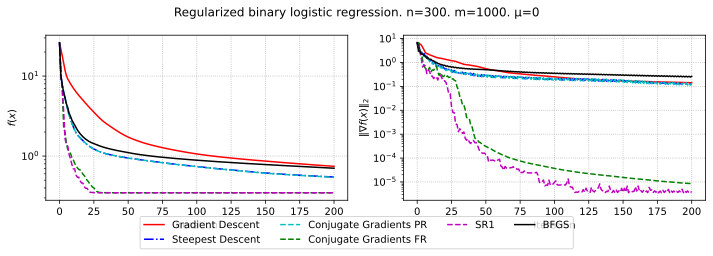

In [9]:
# Experiment parameters
params = {
    "n": 300,
    "m": 1000,
    "mu": 0,
    "alpha": 1e-1,
    "iterations": 200,
    "restart": None
}

results = run_experiment(params)
plot_results(results)

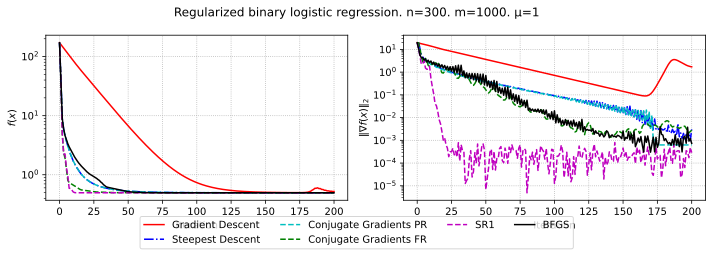

In [10]:
# Experiment parameters
params = {
    "n": 300,
    "m": 1000,
    "mu": 1,
    "alpha": 3e-2,
    "iterations": 200,
    "restart": None
}

results = run_experiment(params)
plot_results(results)

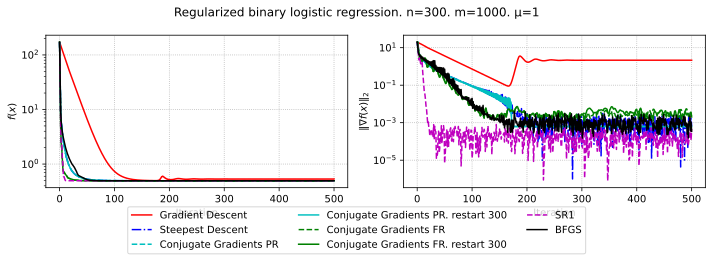

In [11]:
# Experiment parameters
params = {
    "n": 300,
    "m": 1000,
    "mu": 1,
    "alpha": 3e-2,
    "iterations": 500,
    "restart": 300
}

results = run_experiment(params)
plot_results(results)

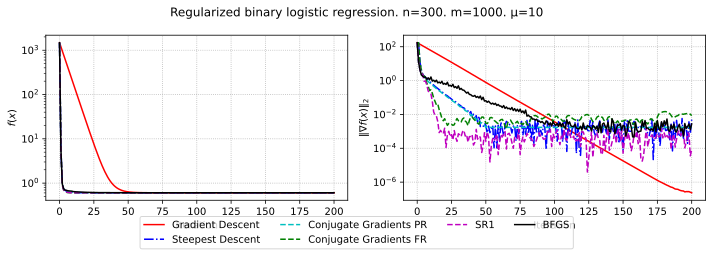

In [12]:
# Experiment parameters
params = {
    "n": 300,
    "m": 1000,
    "mu": 10,
    "alpha": 1e-2,
    "iterations": 200,
    "restart": None
}

results = run_experiment(params)
plot_results(results)

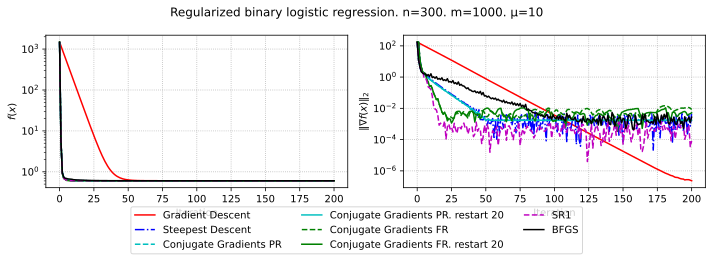

In [13]:
# Experiment parameters
params = {
    "n": 300,
    "m": 1000,
    "mu": 10,
    "alpha": 1e-2,
    "iterations": 200,
    "restart": 20
}

results = run_experiment(params)
plot_results(results)